<a href="https://colab.research.google.com/github/vijayakuruba/IFT6759_Distribution_shifts_WILDS/blob/main/Data_augument.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [3]:
from PIL import Image
from matplotlib import pyplot as plt

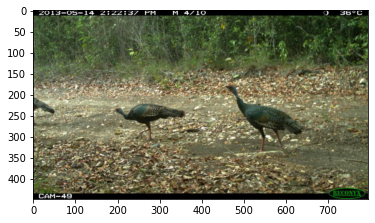

In [4]:
x =Image.open("/content/drive/MyDrive/IFT6135/99599904-21bc-11ea-a13a-137349068a90.jpg")
plt.imshow(x)

In [ ]:
x.size

(796, 448)

In [7]:
%cd /content/drive/MyDrive/IFT6759_Distribution_shifts_WILDS/examples
!ls


/content/drive/MyDrive/IFT6759_Distribution_shifts_WILDS/examples
algorithms	   evaluate.py	models	      test_ID.csv    utils.py
configs		   __init__.py	optimizer.py  test_OOD.csv   wandb
data		   logs_cc	__pycache__   train.csv
data1		   logs_delete	run_expt.py   train.py
data_augmentation  losses.py	scheduler.py  transforms.py


In [8]:
import copy
from typing import List

import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from data_augmentation.randaugment import FIX_MATCH_AUGMENTATION_POOL, RandAugment
from data_augmentation.weak_augment.weakaugment import WEAK_AUGMENTATION_POOL, WeakAugment

In [9]:
target_resolution=(448,448)
_DEFAULT_IMAGE_TENSOR_NORMALIZATION_MEAN = [0.485, 0.456, 0.406]
_DEFAULT_IMAGE_TENSOR_NORMALIZATION_STD = [0.229, 0.224, 0.225]

normalization = transforms.Normalize(
        _DEFAULT_IMAGE_TENSOR_NORMALIZATION_MEAN,
        _DEFAULT_IMAGE_TENSOR_NORMALIZATION_STD,
    )

In [18]:
random_crop=transforms.RandomCrop(size=target_resolution)

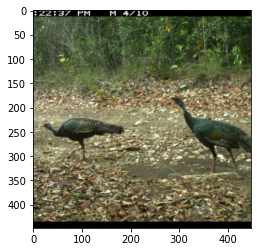

In [23]:
img = random_crop(x)
#img=img.squeeze().permute(1,2,0)
plt.imshow(img)

In [24]:
random_flip=transforms.RandomHorizontalFlip()

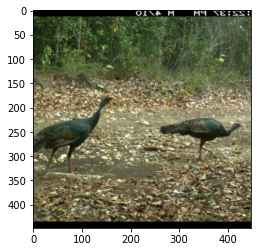

In [26]:
img1 = random_flip(img)
#img=img.squeeze().permute(1,2,0)
plt.imshow(img1)

In [47]:
#weak
#random Horizontal flip + Random crop +Normalise
normalise_transform=([])
normalise_transform.append(transforms.ToTensor())
normalise_transform.append(normalization)
normalise_transform=transforms.Compose(normalise_transform)

# Weak Transform

In [48]:
#weak
#random Horizontal flip + Random crop +Normalise
weak_transform=normalise_transform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


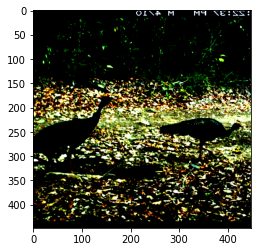

In [49]:
imgw =weak_transform(img1)
imgw=imgw.squeeze().permute(1,2,0)
plt.imshow(imgw)

# Cutout

In [69]:
import torch
from PIL import Image, ImageOps, ImageEnhance, ImageDraw

def Cutout(img, v):  # [0, 60] => percentage: [0, 0.2] => change to [0, 0.5]
    assert 0.0 <= v <= 0.5

    v = v * img.size[0]
    return CutoutAbs(img, v)


def CutoutAbs(img, v):  # [0, 60] => percentage: [0, 0.2]
    if v < 0:
        return img
    w, h = img.size
    x_center = 224
    y_center = 224

    x0 = int(max(0, x_center - v / 2.0))
    y0 = int(max(0, y_center - v / 2.0))
    x1 = min(w, x0 + v) 
    y1 = min(h, y0 + v)

    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    img = img.copy()
    ImageDraw.Draw(img).rectangle(xy, color)
    return img



class CutoutAugment:
    #def __init__(self):
        #assert n >= 1, "RandAugment N has to be a value greater than or equal to 1."
        #self.n = n
        #self.augmentation_pool = augmentation_pool

    def __call__(self, img):
        #ops = [
        #    self.augmentation_pool[torch.randint(len(self.augmentation_pool), (1,))]
        #    for _ in range(self.n)
        #]
        #for op, min_val, max_val in ops:
        #    val = min_val + float(max_val - min_val) * _sample_uniform(0, 1)
        #    img = op(img, val)
        cutout_val =  0.5
        img = Cutout(img, cutout_val)
        return img

In [58]:
#cutout_transform=([CutoutAugment()])

cutout_transform=CutoutAugment()

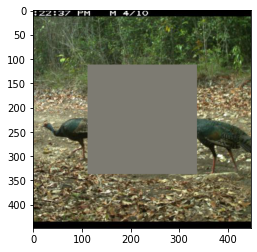

In [68]:
imgc =cutout_transform(img)
#imgc=imgc.squeeze().permute(1,2,0)
plt.imshow(imgc)

In [ ]:
import torch
from PIL import Image, ImageOps, ImageEnhance, ImageDraw


def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    v = v * img.size[0]
    return img.transform(img.size, Image.AFFINE, (1, 0, v, 0, 1, 0))

def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    v = v * img.size[1]
    return img.transform(img.size, Image.AFFINE, (1, 0, 0, 0, 1, v))



WEAK_AUGMENTATION_POOL = [
    (TranslateX, -0.3, 0.3),
    (TranslateY, -0.3, 0.3),
]


class WeakAugment:
    def __init__(self, augmentation_pool):
        self.augmentation_pool = augmentation_pool

    def __call__(self, img):
        ops = [
            self.augmentation_pool[torch.randint(len(self.augmentation_pool), (1,))]
        ]
        for op, min_val, max_val in ops:
            val = min_val + float(max_val - min_val) 
            img = op(img, val)
        return img

In [ ]:
def add_weakenhanced_transform(config, dataset, base_transform_steps, normalization):
  
    target_resolution = _get_target_resolution(config, dataset)
    weak_transform_steps = copy.deepcopy(base_transform_steps)
    weak_transform_steps.extend(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(
                size=target_resolution
            ),
            WeakAugment(
                
                augmentation_pool=WEAK_AUGMENTATION_POOL,
            ),
            transforms.ToTensor(),
            normalization,
        ]
    )
    return transforms.Compose(weak_transform_steps)

In [5]:
should_normalize = True 
weakm_transform=([
          transforms.RandomCrop(size=target_resolution),
            CutoutAugment(),
        ])

if should_normalize:
   cutout_transform.append(transforms.ToTensor())
   cutout_transform.append(normalization)
cutout_transform=transforms.Compose(cutout_transform)

NameError: ignored

In [ ]:
should_normalize = True # True/False
strong_transform=([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(
                size=target_resolution
            ),
            RandAugment(
                n=2,
                augmentation_pool=FIX_MATCH_AUGMENTATION_POOL,
            ),
        ])

if should_normalize:
   strong_transform.append(transforms.ToTensor())
   strong_transform.append(normalization)
strong_transform=transforms.Compose(strong_transform)


#Randaugument 

Without normalisation

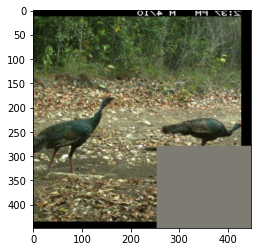

In [ ]:
img = strong_transform(x)
#img=img.squeeze().permute(1,2,0)
plt.imshow(img)

with Normalisation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


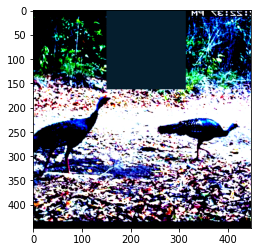

In [ ]:
img1 = strong_transform(x)
img1=img1.squeeze().permute(1,2,0)
plt.imshow(img1)

#Weak Augument

In [ ]:
should_normalize = True #True/False
weak_transform = (
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(
                size=target_resolution,
          ),
        ]
    )
if should_normalize:
   weak_transform.append(transforms.ToTensor())
   weak_transform.append(normalization)
weak_transform = transforms.Compose(weak_transform)

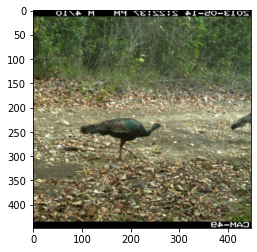

In [ ]:
img2 = weak_transform(x)
#img2=img2.squeeze().permute(1,2,0)
plt.imshow(img2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


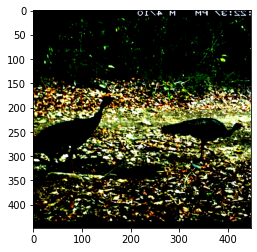

In [ ]:
img3 = weak_transform(x)
img3=img3.squeeze().permute(1,2,0)
plt.imshow(img3)

In [ ]:
%cd /content/drive/MyDrive/IFT6759_Distribution_shifts_WILDS/examples
!ls

/content/drive/MyDrive/IFT6759_Distribution_shifts_WILDS/examples
algorithms  data_augmentation  logs	  optimizer.py	scheduler.py   utils.py
configs     evaluate.py        losses.py  __pycache__	train.py
data	    __init__.py        models	  run_expt.py	transforms.py


#Cutout Augument

In [ ]:
from data_augmentation.cutout_augment.cutoutaugment import CutoutAugment
#from data_augmentation.randaugment import FIX_MATCH_AUGMENTATION_POOL, RandAugment


In [ ]:
should_normalize = True # True/False
cutout_transform=([
          transforms.RandomCrop(size=target_resolution),
            CutoutAugment(),
        ])

if should_normalize:
   cutout_transform.append(transforms.ToTensor())
   cutout_transform.append(normalization)
cutout_transform=transforms.Compose(cutout_transform)

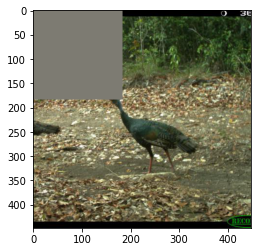

In [ ]:
img4 = cutout_transform(x)
#img2=img2.squeeze().permute(1,2,0)
plt.imshow(img4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


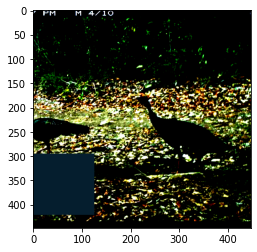

In [ ]:
img5 = cutout_transform(x)
img5=img5.squeeze().permute(1,2,0)
plt.imshow(img5)

In [ ]:
should_normalize = True # True/False
weak1_transform=([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(
                size=target_resolution
            ),
            WeakAugment(
              
                augmentation_pool=WEAK_AUGMENTATION_POOL,
            ),
        ])

if should_normalize:
   weak1_transform.append(transforms.ToTensor())
   weak1_transform.append(normalization)
weak1_transform=transforms.Compose(weak1_transform)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


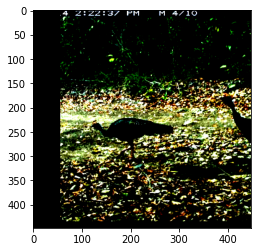

In [ ]:
img6 = weak1_transform(x)
img6=img6.squeeze().permute(1,2,0)
plt.imshow(img6)